# Изучение закономерностей, определяющих успешность игр

### Описание проекта
Клиент - Интернет-магазин «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). **Необходимо выявить определяющие успешность игры закономерности**. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й. Нужно отработать принцип работы с данными. 

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

Описание данных:

- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

### Оглавление
1. [Открытие данных](#start)    
    
    
2. [Подготовка данных](#preprocessing)
    * [Обработка пропущенных значений](#null)
    * [Подсчет суммарных продаж](#sumsale)


3. [Исследовательский анализ данных](#research)
    * [Исследование игровых платформ](#platform)
    * [Исследование отзывов](#feedback)
    * [Исследование игровых жанров](#genre)
   
   
4. [Портрет пользователя каждого региона](#user)
    * [Популярные платформы](#topplatform)
    * [Популярные жанры](#topgenre)
    * [Влияние рейтинга ESRB](#rating)
    
    
5. [Проверка гипотез](#hypothesis)


6. [Общие выводы](#conclusions)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import seaborn as sns

### Откроем файл с данными и изучим общую информацию
<a id="start"></a>

In [2]:
# функция для удобства чтения файлов локально и на сервере школы

def read_csv(file):
    file = 'datasets/' + file + '.csv'
    try:
        return pd.read_csv('/' + file)
    except FileNotFoundError:
        return pd.read_csv(file)

In [3]:
# откроем файл
games = read_csv('games') 
games

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


*Name* - проверить на дубликаты. Одна игра может выходить на разных платформах, и поэтому появляться на нескольких строках, такие строки мы оставим, так как разные платформы имеют разную аудиторию, а сами игры могут иметь разные особенности ("фичи"). 

*Year_of_Release* - привести к типу *int*, если возможно, для удобства работы с данными. 

*User_Score* - привести к типу *float*. 

Рассмотрим данные детальнее, определим пропуски, дубликаты и ошибки, исправим, где это возможно.

### Подготовка данных
<a id="preprocessing"></a>


- Замените названия столбцов (приведите к нижнему регистру);
- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;

In [5]:
# заменим названия столбцов (приведем к нижнему регистру)
games.columns = games.columns.str.lower()
games.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


Преобразуем данные в нужные типы.

In [6]:
# посмотрим на значения
games['year_of_release'].unique() 

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Значений типа *str* или нереалистичных нет. Оставляем тип float, так как в данных присутствуют NaN. Не критично, так как данные будут воспринимать целые числа несмотря на формат вывода.

In [7]:
# посмотрим значения в 'user_score'
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Выделяется одно строчное значение *tbd* - означает 'to be determined' (от англ. 'быть определенным'), т.е. ожидает оценки. Заменим такие значения на NaN-ы, так как оценки на текущий момент нет.

In [8]:
# заменим 'tbd' на NaN 
games['user_score'] = games['user_score'].replace('tbd', np.nan)

In [9]:
# приведем к float
games['user_score'] = games['user_score'].astype(float)

In [10]:
games['user_score'].unique()

array([8. , nan, 8.3, 8.5, 6.6, 8.4, 8.6, 7.7, 6.3, 7.4, 8.2, 9. , 7.9,
       8.1, 8.7, 7.1, 3.4, 5.3, 4.8, 3.2, 8.9, 6.4, 7.8, 7.5, 2.6, 7.2,
       9.2, 7. , 7.3, 4.3, 7.6, 5.7, 5. , 9.1, 6.5, 8.8, 6.9, 9.4, 6.8,
       6.1, 6.7, 5.4, 4. , 4.9, 4.5, 9.3, 6.2, 4.2, 6. , 3.7, 4.1, 5.8,
       5.6, 5.5, 4.4, 4.6, 5.9, 3.9, 3.1, 2.9, 5.2, 3.3, 4.7, 5.1, 3.5,
       2.5, 1.9, 3. , 2.7, 2.2, 2. , 9.5, 2.1, 3.6, 2.8, 1.8, 3.8, 0. ,
       1.6, 9.6, 2.4, 1.7, 1.1, 0.3, 1.5, 0.7, 1.2, 2.3, 0.5, 1.3, 0.2,
       0.6, 1.4, 0.9, 1. , 9.7])

Типы данных исправлены.

##### Обработка пропущенных значений
<a id="null"></a> 

Обработайте пропуски при необходимости:

- Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
- Опишите причины, которые могли привести к пропускам;
- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [11]:
# функция для вывода процента пропусков от общего значения

def show(count, total):
    print(f'{count} / {total} = {100 * count / total:.2f}%')

In [12]:
# посмотрим строки с пропусками в названиях игр
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [13]:
show(games['name'].isna().sum(), len(games))

2 / 16715 = 0.01%


Строки имеют крайне мало информации, полезной для анализа, мы их можем просто удалить. Отметим, что жанры в этих строках также NaN, и судя по games.info(), только у них. Пропуски могли появиться как ошибка при заполнении данных, возможно, были неполные данные по играм из 90-х, и имя игры было потеряно.

In [14]:
# удалим строки 659 и 14244
games = games.dropna(subset=['name'])
games['name'].isna().sum()

0

In [15]:
# уникальные значения в 'name'
len(games['name'].unique()) 

11559

Есть 5155 строк с одним и тем же названием игры, тем не менее дубликатами мы их не можем считать, так как одна и та же игра может выходить на разных платформах и можно считать, что это разные игры, на разных платформах разное сообщество пользователей, продажи и особенности игры. 

Проверим есть ли дубликаты с одним и тем же 'name' и 'platform', сгруппируем по названию и платформе и выведем тех, где в группе больше одной игры.


In [16]:
# проверияем дубликаты 

games[['name', 'platform']].duplicated().sum()

4

In [17]:
# группируем

t = games.groupby(['name', 'platform']).size()
t[t > 1]

name                         platform
Madden NFL 13                PS3         2
Need for Speed: Most Wanted  PC          2
                             X360        2
Sonic the Hedgehog           PS3         2
dtype: int64

Таких всего восемь игр.

Если добавить год выпуска (возможно это существенные дополнения, вышедшие в разные года), то останется только одна игра Madden NFL 13, на PS3, 2012 года.

In [18]:
t = games.groupby(['name', 'platform', 'year_of_release']).size()
t[t > 1]

name           platform  year_of_release
Madden NFL 13  PS3       2012.0             2
dtype: int64

In [19]:
# выведем ее

mask = (games['name'] == "Madden NFL 13") & (games['platform'] == "PS3")
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Как видим, отличаются только продажи. Возможно, к нам пришла информация о продажах разных дестрибьютеров, которые продавали игру в своих регионах. Заменим эти две строки на одну, сложив количество продаж.

In [20]:
# сложим sales

games.at[604,'eu_sales']=0.23
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


In [21]:
# удалим строку 16230

games = games.drop([16230])
mask = (games['name'] == "Madden NFL 13") & (games['platform'] == "PS3")

games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.23,0.0,0.23,83.0,5.5,E


Посмотрим на другие дубликаты:

In [22]:
# Need for Speed: Most Wanted  PC

mask = (games['name'] == "Need for Speed: Most Wanted") & (games['platform'] == "PC")
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.0,0.04,82.0,8.5,T
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.00,0.06,0.0,0.02,82.0,8.5,T


In [23]:
# Need for Speed: Most Wanted  X360

mask = (games['name'] == "Need for Speed: Most Wanted") & (games['platform'] == "X360")
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T


Игра "Need for Speed: Most Wanted" выходила в 2005 и в 2012, в обоих годах она вышла и на X360, и на PC. Это важные различия, оставим строки. Версии разного года имеют различия в графике, кастомизации, геймплее. Также, одна и та же игра на разной платформе должна рассматриваться как отдельная игра из-за возможных различий в группах пользователей.

In [24]:
# Sonic the Hedgehog PS3

mask = (games['name'] == "Sonic the Hedgehog") & (games['platform'] == "PS3")
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+


Судя по одной и той же платформе и оценках пользователей и критиков, можно предположить, что эти строки являются дубликатами. Объединим, сложив продажи. Насколько известно, игра под таким названием выходила только в 2006.

In [25]:
# сложим продажи 
games.at[1745,'eu_sales']=0.54

# удалим строку 4127
games = games.drop([4127])

mask = (games['name'] == "Sonic the Hedgehog") & (games['platform'] == "PS3")

games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1745,Sonic the Hedgehog,PS3,2006.0,Platform,0.41,0.54,0.04,0.66,43.0,4.1,E10+


Дубликаты устранены.

In [26]:
# посчитаем количество строк с незаполненным годом
show(games['year_of_release'].isna().sum(), len(games))

268 / 16711 = 1.60%


In [27]:
mask = games['year_of_release'].isna()
print('Игр с незаполеннным годом выпуска:', mask.sum())

Игр с незаполеннным годом выпуска: 268


In [28]:
# посмотрим на строки без заполненного года

mask = games['year_of_release'].isna()
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Мультиплатформенные игры, могут иметь заполненный год не во всех строках, т.е. не для всех платформ. Для некоторых игр мы можем "вытащить" год из названия (пример: "FIFA Soccer 2004"). Также если год известен для одной из платформ, можно предположить, что другие платформы были в тот же год. Но важно отметить, что версия для другой платформы могла присоединиться позже с важными изменениями, и в таком случае заменять на один год - не верно. 

In [29]:
# рассмотрим на примере одной из игр

name = 'LEGO Batman: The Videogame'
mask = games['name'] == name
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
397,LEGO Batman: The Videogame,X360,2008.0,Action,2.04,1.02,0.0,0.32,76.0,7.9,E10+
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.0,0.29,74.0,7.9,E10+
460,LEGO Batman: The Videogame,DS,2008.0,Action,1.75,1.01,0.0,0.29,72.0,8.0,E10+
1519,LEGO Batman: The Videogame,PS3,2008.0,Action,0.72,0.39,0.0,0.19,75.0,7.7,E10+
1538,LEGO Batman: The Videogame,PSP,NaN,Action,0.57,0.44,0.0,0.27,73.0,7.4,E10+
1553,LEGO Batman: The Videogame,PS2,2008.0,Action,0.72,0.03,0.0,0.52,77.0,8.9,E10+
12465,LEGO Batman: The Videogame,PC,2008.0,Action,0.02,0.03,0.0,0.01,80.0,7.8,E10+


Скорее всего *Wii* и *PSP* тоже вышли в 2008. Проверив онлайн, видим, что действительно "LEGO Batman: The Videogame" для PSP и Wii вышли в 2008.

Проверим есть ли игры, которые на разных платформах выходили в разные года, при этом для некоторых платформ год не заполнен. Если такие есть, то мы, к сожалению, не можем принять решение подставить один и тот же год для всех строк с одинаковым названием игры.

In [30]:
# определим игры, которые содержат хотя бы один пропуск в году выпуска

mask = games['year_of_release'].isna()
names = games[mask]['name']

# 2. получим словрь минимальных лет и максимальных лет выпуска для всех игр

max_years = games[['name', 'year_of_release']].groupby('name').max()['year_of_release'].to_dict()
min_years = games[['name', 'year_of_release']].groupby('name').min()['year_of_release'].to_dict()

# 3. пробежимся по играм с пропусками года выпуска и 

for name in list(names):
    if max_years[name] > 0:
        if max_years[name] != min_years[name]:
            print(name)

Space Invaders
Hitman 2: Silent Assassin
Wheel of Fortune
Namco Museum
PES 2009: Pro Evolution Soccer
Tomb Raider (2013)
College Hoops 2K6
Smashing Drive
Rayman Arena
Tom and Jerry in War of the Whiskers
Mario Tennis


Такие игры все же есть, проверим одну из них:

In [31]:
mask = games['name'] == 'Tomb Raider (2013)'
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
646,Tomb Raider (2013),PS3,2013.0,Action,0.60,1.26,0.08,0.48,NaN,NaN,NaN
910,Tomb Raider (2013),X360,2013.0,Action,0.86,0.84,0.01,0.17,NaN,NaN,NaN
1384,Tomb Raider (2013),PS4,2014.0,Action,0.47,0.65,0.06,0.22,NaN,NaN,NaN
3309,Tomb Raider (2013),XOne,2014.0,Action,0.35,0.21,0.00,0.05,NaN,NaN,NaN
5336,Tomb Raider (2013),PC,NaN,Action,0.06,0.25,0.00,0.04,86.0,8.5,M


Видим, что игра выходила в разные годы на разных платформах.

Все же предположим, что в большинстве случаев год выпуска игры на разных платформах одинаков. Заменим пропуски на минимальный год.

In [32]:
# получаем минимальный год по каждой игре и переводим это в словарь

mask = games['year_of_release'].isna()
games.loc[mask, 'year_of_release'] = games[mask]['name'].apply(lambda name: min_years.get(name, None))

mask = games['year_of_release'].isna()
print('Игр с незаполеннным годом выпуска:', mask.sum())

Игр с незаполеннным годом выпуска: 146


In [33]:
# заменим там, где можем взять год из названия

import re
def get_year_from_name(name):
    q = re.search('\d{4}', name)
    year = int(q.group()) if q else 0
    return year if 1980 <= year <= 2017 else None

# проверим себя

for name in [
    'Hitman 1000',
    'Tomb Raider (2013)', 
    'PES 2009: Pro Evolution Soccer', 
    'Hitman 2: Silent Assassin',
    'Namco Museum']:
    print(f'{name}: {get_year_from_name(name)}')

Hitman 1000: None
Tomb Raider (2013): 2013
PES 2009: Pro Evolution Soccer: 2009
Hitman 2: Silent Assassin: None
Namco Museum: None


In [34]:
# применим функцию и посчитаем пропуски 

mask = games['year_of_release'].isna()
games.loc[mask, 'year_of_release'] = games[mask]['name'].apply(get_year_from_name)

mask = games['year_of_release'].isna()
print('Игр с незаполеннным годом выпуска:', mask.sum())

Игр с незаполеннным годом выпуска: 139


In [35]:
# изменилось 
show(games['year_of_release'].isna().sum(), len(games))

139 / 16711 = 0.83%


In [36]:
# посмотрим пропуски в 'critic_score'
show(games['critic_score'].isna().sum(), len(games))

8576 / 16711 = 51.32%


In [37]:
# посмотрим пропуски в 'user_score'
show(games['user_score'].isna().sum(), len(games))

9123 / 16711 = 54.59%


In [38]:
# посмотрим какие значения есть в рейтинге
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [39]:
# посмотрим пропуски в 'rating'
show(games['rating'].isna().sum(), len(games))

6764 / 16711 = 40.48%


Рейтинг игры в большей части будет одинаков вне зависимости от платформы. Мы можем заполнить такие пропуски.

In [40]:
# заменим пропуски рейтингов игр по известному рейтингу на других платформах

mask = games['rating'].notna()
rating_names = games[['name', 'rating']][mask].groupby('name').min()['rating'].to_dict()

mask = games['rating'].isna()
games.loc[mask, 'rating'] = games[mask]['name'].apply(lambda name: rating_names.get(name, None))

mask = games['rating'].isna()
print('Игр с незаполеннным рейтингом:', mask.sum())

Игр с незаполеннным рейтингом: 6327


In [41]:
# проверка
rating_names['Tomb Raider (2013)']

'M'

In [42]:
mask = games['name'] == 'Tomb Raider (2013)'
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
646,Tomb Raider (2013),PS3,2013.0,Action,0.60,1.26,0.08,0.48,NaN,NaN,M
910,Tomb Raider (2013),X360,2013.0,Action,0.86,0.84,0.01,0.17,NaN,NaN,M
1384,Tomb Raider (2013),PS4,2014.0,Action,0.47,0.65,0.06,0.22,NaN,NaN,M
3309,Tomb Raider (2013),XOne,2014.0,Action,0.35,0.21,0.00,0.05,NaN,NaN,M
5336,Tomb Raider (2013),PC,2013.0,Action,0.06,0.25,0.00,0.04,86.0,8.5,M


Пропуски в рейтинге заполним на "unknown".

In [43]:
games['rating'] = games['rating'].fillna('unknown')
games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,unknown
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,unknown
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,unknown
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,unknown


In [44]:
games['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [45]:
# проверка
show(games['rating'].isna().sum(), len(games))

0 / 16711 = 0.00%


*critic_score* и *user_score* - дубликатов практически нет, но можно заполнить по среднему оценок на других платформах для этой конкретной игры, если, конечно, игра выходила на других платформах.

У нас есть огромное количество пропусков в столбцах с оценками критиков или пользователей. Посмотрим на несколько примеров игр, у которых есть несколько строк с одним и тем же названием.

In [46]:
name = 'Super Mario Bros.'
mask = games['name'] == name
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
201,Super Mario Bros.,GB,1999.0,Platform,3.40,1.30,0.15,0.22,NaN,NaN,unknown


In [47]:
name = 'Winning Post 8 2016'
mask = games['name'] == name
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
15599,Winning Post 8 2016,PS4,2016.0,Simulation,0.0,0.0,0.02,0.0,NaN,NaN,unknown
16714,Winning Post 8 2016,PSV,2016.0,Simulation,0.0,0.0,0.01,0.0,NaN,NaN,unknown


In [48]:
name = 'Samurai Warriors: Sanada Maru'
mask = games['name'] == name
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
14689,Samurai Warriors: Sanada Maru,PS4,2016.0,Action,0.0,0.0,0.03,0.0,NaN,NaN,unknown
16323,Samurai Warriors: Sanada Maru,PSV,2016.0,Action,0.0,0.0,0.01,0.0,NaN,NaN,unknown
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.0,0.0,0.01,0.0,NaN,NaN,unknown


In [49]:
mask = games['name'] == 'LEGO Batman: The Videogame'
games[mask]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
397,LEGO Batman: The Videogame,X360,2008.0,Action,2.04,1.02,0.0,0.32,76.0,7.9,E10+
456,LEGO Batman: The Videogame,Wii,2008.0,Action,1.80,0.97,0.0,0.29,74.0,7.9,E10+
460,LEGO Batman: The Videogame,DS,2008.0,Action,1.75,1.01,0.0,0.29,72.0,8.0,E10+
1519,LEGO Batman: The Videogame,PS3,2008.0,Action,0.72,0.39,0.0,0.19,75.0,7.7,E10+
1538,LEGO Batman: The Videogame,PSP,2008.0,Action,0.57,0.44,0.0,0.27,73.0,7.4,E10+
1553,LEGO Batman: The Videogame,PS2,2008.0,Action,0.72,0.03,0.0,0.52,77.0,8.9,E10+
12465,LEGO Batman: The Videogame,PC,2008.0,Action,0.02,0.03,0.0,0.01,80.0,7.8,E10+


После проверки некоторых игр, можно заметить, что как правило если оценка отсутствует для одной платформы, то оценки нет в принципе для игры и для всех ее плафторм. Мы все равно не сможем заменить пропуски.

Также видно, что для некоторых игр, оценки на разных платформах - разные, что не дает нам уверенности в дублирование оценок по названию игры.

##### Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец
<a id="sumsale"></a>

In [50]:
games.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


In [51]:
# создадим новый столбце с суммарными продажами по всем регионам
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38


### Шаг 3. Исследовательский анализ данных
<a id="research"></a>

##### Исследование игровых платформ
<a id="platform"></a>

Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [52]:
# количество игр в каждый год

games.groupby(["year_of_release"]).size()

year_of_release
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      60
1994.0     122
1995.0     219
1996.0     263
1997.0     290
1998.0     379
1999.0     339
2000.0     351
2001.0     486
2002.0     845
2003.0     784
2004.0     764
2005.0     950
2006.0    1020
2007.0    1203
2008.0    1441
2009.0    1430
2010.0    1269
2011.0    1154
2012.0     661
2013.0     548
2014.0     581
2015.0     606
2016.0     502
dtype: int64

Посчитаем количество уникальных игр (без учета платформы):


In [53]:
# группируем по году и имени

t = games.groupby(["year_of_release", "name"]).size()
t

year_of_release  name                                               
1980.0           Asteroids                                              1
                 Boxing                                                 1
                 Bridge                                                 1
                 Checkers                                               1
                 Defender                                               1
                                                                       ..
2016.0           Ys VIII: Lacrimosa of Dana                             1
                 Yuusha Shisu.                                          1
                 Zero Escape: Zero Time Dilemma                         2
                 Zettai Kaikyuu Gakuen: Eden with Roses and Phantasm    1
                 ZombiU                                                 2
Length: 12201, dtype: int64

In [54]:
# и далее группируем по году
t.groupby("year_of_release").size()

year_of_release
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      40
1992.0      41
1993.0      59
1994.0     117
1995.0     215
1996.0     258
1997.0     282
1998.0     364
1999.0     326
2000.0     325
2001.0     428
2002.0     631
2003.0     547
2004.0     550
2005.0     658
2006.0     775
2007.0     885
2008.0    1039
2009.0    1001
2010.0     900
2011.0     780
2012.0     446
2013.0     335
2014.0     319
2015.0     362
2016.0     297
dtype: int64

Посчитаем количество уникальных платформ для каждой игры:


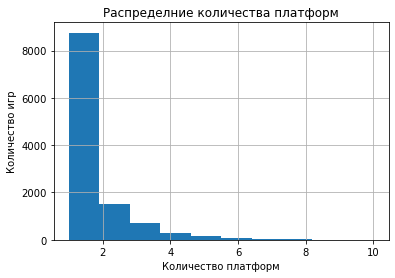

In [55]:
# построем гистограмму

t = games[['name', 'platform']].drop_duplicates()
ax = t.groupby(['name']).count()['platform'].hist()
_ = ax.set_title('Распределние количества платформ')
_ = ax.set_xlabel('Количество платформ')
_ = ax.set_ylabel('Количество игр')

Заметный рост в популярности игр заметен с 1994 года. Появилась 3D-графика, что породило новые жанры игр, также появились домашние консоли, стали уходить аркадные игры.

Видим, что аномально большие числа в период с 2006 по 2011. Из гистограммы видно, что это связано с тем, что игры выходили на большом количестве разных платформ. Судя по всему, потом платформ стало меньше - какие-то устарели, не выдержали конкуренцию.

Можно рассмотривать данные по десятилетиям, чтобы понять как меняются тренды на всем протяжении существования индустрии, так как она, относительно молодая. Но скорее всего информация только за последние 5-10 лет будет актуальна для прогнозирования на следующий год, учитывая динамику развития новый игр и технологий.

##### Посмотрим, как менялись продажи по платформам:
- Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. 
- За какой характерный срок появляются новые и исчезают старые платформы?

In [56]:
# посмотрим сколько платформ у нас есть 
len(games['platform'].unique())

31

In [57]:
# посмотрим значения платформ
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [58]:
# для каждой платформы посмотрим год и количество продаж в этом году 

platform_sales_year = games.pivot_table(
    index=['platform', 'year_of_release'],
    values=['total_sales'],
    aggfunc='sum'
)
platform_sales_year

total_sales
platform year_of_release             
2600     1980.0                 11.38
         1981.0                 35.68
         1982.0                 28.88
         1983.0                  5.84
         1984.0                  0.27
...                               ...
XB       2008.0                  0.18
XOne     2013.0                 18.96
         2014.0                 54.07
         2015.0                 60.14
         2016.0                 26.15

[244 rows x 1 columns]

In [59]:
# выбирем платформы с наибольшими суммарными продажами 

top_platforms = games[['platform', 'total_sales']].groupby('platform').sum()\
    .sort_values(by='total_sales', ascending=False)

top_platforms

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


In [60]:
# изучим топ-10

platform_top_10 = top_platforms[:10]
platform_top_10

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


In [61]:
# выведем названия топ-10 платформ
platform_top_10.index

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'GBA', 'PS4', 'PSP', 'PC'], dtype='object', name='platform')

In [62]:
platform_sales_year.head(3)

total_sales
platform year_of_release             
2600     1980.0                 11.38
         1981.0                 35.68
         1982.0                 28.88

In [63]:
# platform_sales_year в индексе содержит пару значений 
# воспользуемся unstack

s = platform_sales_year['total_sales'].unstack(level=0)
s.head()

platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,...,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
year_of_release,,,,,,,,,,,,,,,,,,,,,
1980.0,11.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981.0,35.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982.0,28.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983.0,5.84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984.0,0.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
# берем только столбцы для топ 10 платформ

s = s[platform_top_10.index]
s

platform,PS2,X360,PS3,Wii,DS,PS,GBA,PS4,PSP,PC
year_of_release,,,,,,,,,,
1980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985.0,NaN,NaN,NaN,NaN,0.02,NaN,NaN,NaN,NaN,0.04
1986.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1988.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03


Построим распределение продаж для топ-платформ по годам. Зададим диапазон лет через xlim. Поставим с 1992, т.к. с этого года заметен значительный рост в количестве игровых платформ.

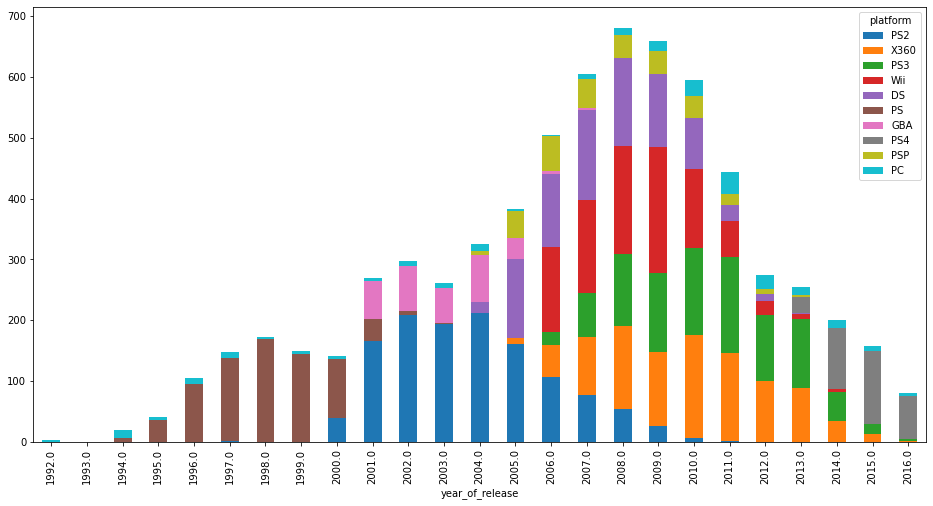

In [65]:
top_platform_years = s[1992:].plot.bar(figsize=(16, 8), xlim=(1992, 2016), stacked=True)

##### За какой характерный срок появляются новые и исчезают старые платформы?

Видно, что в среднем платформы "живут" в течение 8-10 лет. Также, видно, что с 2006 по 2011 год было самое большое количество игровых платформ. 

Можно предположить, что, например, PS4 еще будет использоваться по 2021-2023 год. А также, возможно, появятся новые плафтормы.

##### Возьмите данные за соответствующий актуальный период:
- Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.

**Первый вариант**:

За актуальный период возьмем период в 10 лет с 2006 по 2016 гг. Из графиков видно, что многие имеют нормальное распределение с основанием порядка 10 лет, в этот период выходят игры на той или иной платформе. Такой период позволяет нам посмотреть уходит ли та или иная платформа и наоборот.

In [66]:
period = games['year_of_release'] >= 2006 
games_new = games[period]

# посмотрим количество платформ, используемых в этот период
len(games_new['platform'].unique())

16

##### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ

In [67]:
top_platforms_new = games_new[['platform', 'total_sales']].groupby('platform').sum()\
    .sort_values(by='total_sales', ascending=False)

platform_top_10_new = top_platforms_new[:10]
platform_top_10_new

,total_sales
platform,
X360,957.45
PS3,935.00
Wii,903.31
DS,656.85
PS4,314.14
PS2,269.52
3DS,258.51
PSP,242.67
PC,166.46


In [68]:
# оставим только игры на самых популярных платформах

mask = games_new['platform'].apply(lambda q: q in platform_top_10_new.index)
games_new = games_new[mask]

Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

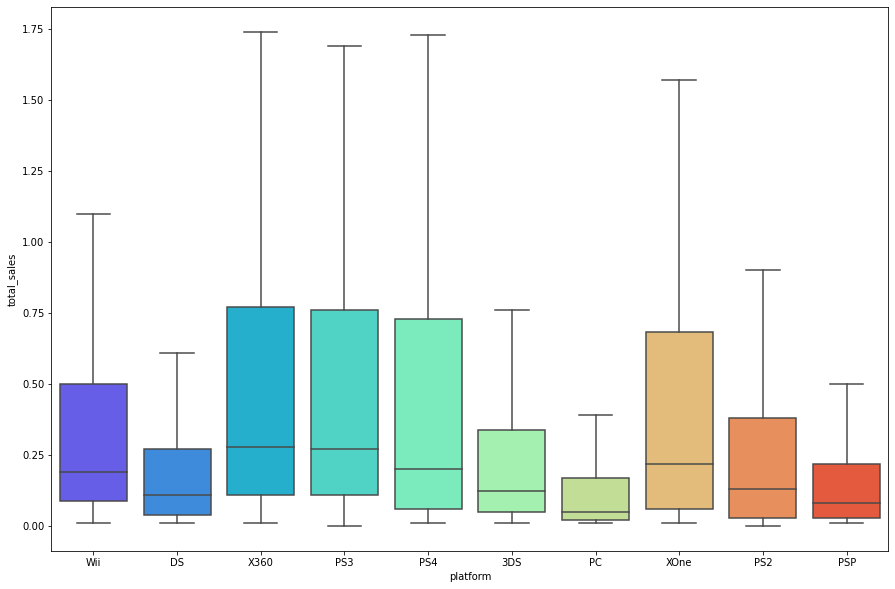

In [69]:
# график «ящик с усами» по глобальным продажам игр в разбивке по платформам

fig, ax = plt.subplots()
sns.boxplot(x="platform", y="total_sales", data=games_new, palette='rainbow', showfliers=False)
fig.set_size_inches(15, 10)

Самые прибыльные платформы: X360, PS3, PS4, XOne. Игровые приставки лидируют. Вполне ожидаемо, так как такие платформы заточены именно под игры, соответсвенно в игры легче играть, их легче устанавливать, также консольные игры, как правило дешевле.

##### Исследование отзывов
<a id="feedback"></a>  

Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Сейчас 'critic_score' максимум 100, а 'user_score' - 10, приведем к одному максимуму, чтобы построить на одном графике:



In [70]:
games_new['user_score_100'] = games_new['user_score']*10
games_new.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,user_score_100
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,80.0
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,83.0
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,80.0
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80,85.0
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91,66.0


In [71]:
# как пример возьмем PS4

mask = games_new['platform'] == "PS4"
PS4 = games_new[mask]
PS4.head(3)

# нас волнуют 'critic_score' & 'user_score' & 'total_score'

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,user_score_100
31,Call of Duty: Black Ops 3,PS4,2015.0,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63,NaN
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62,83.0
77,FIFA 16,PS4,2015.0,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58,43.0


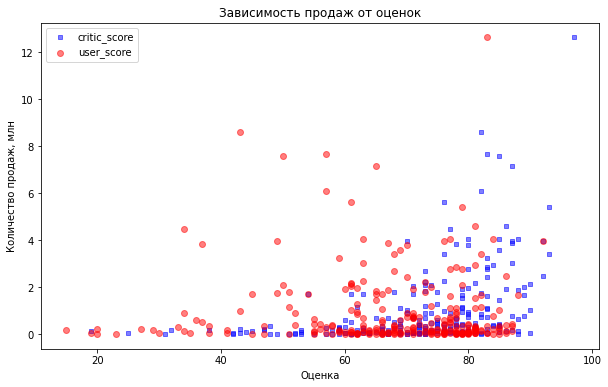

In [72]:
# график рассеяния для PS4
plt.figure(figsize=(10,6))

plt.scatter(PS4['critic_score'], PS4['total_sales'], alpha=0.5, s=10, c='b', marker="s", label='critic_score')
plt.scatter(PS4['user_score_100'], PS4['total_sales'], alpha=0.5, c='r', marker="o", label='user_score')

plt.title('Зависимость продаж от оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество продаж, млн')

plt.legend(loc='upper left')
plt.show()

In [73]:
# еще один пример - X360

mask = games_new['platform'] == "X360"
X360 = games_new[mask]
X360.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,user_score_100
14,Kinect Adventures!,X360,2010.0,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82,63.0
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27,81.0
29,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73,34.0


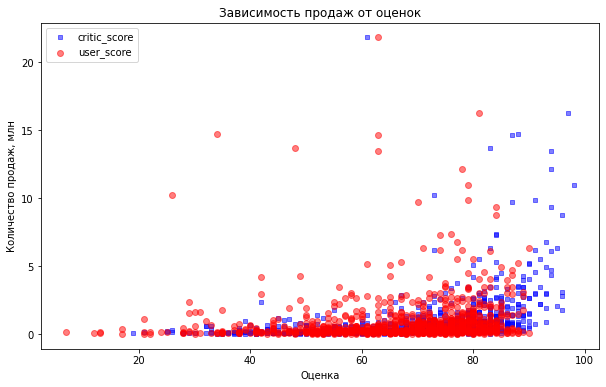

In [74]:
# график рассеяния для X360

plt.figure(figsize=(10,6))

plt.scatter(X360['critic_score'], X360['total_sales'], alpha=0.5, s=10, c='b', marker="s", label='critic_score')
plt.scatter(X360['user_score_100'], X360['total_sales'], alpha=0.5, c='r', marker="o", label='user_score')

plt.title('Зависимость продаж от оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество продаж, млн')

plt.legend(loc='upper left')
plt.show()

Посчитаем корреляцию между отзывами и продажами:


In [75]:
corr_PS4_critic = PS4['critic_score'].corr(PS4['total_sales'])
corr_PS4_user = PS4['user_score'].corr(PS4['total_sales'])

corr_X360_critic = X360['critic_score'].corr(X360['total_sales'])
corr_X360_user = X360['user_score'].corr(X360['total_sales'])

print('Корреляция PS4 отзывы критиков к общим продажам:', f'{corr_PS4_critic:.2f}')
print('Корреляция PS4 отзывы пользователей к общим продажам:', f'{corr_PS4_user:.2f}')
print()
print('Корреляция X360 отзывы критиков к общим продажам:', f'{corr_X360_critic:.2f}')
print('Корреляция X360 отзывы пользователей к общим продажам:', f'{corr_X360_user:.2f}')

Корреляция PS4 отзывы критиков к общим продажам: 0.41
Корреляция PS4 отзывы пользователей к общим продажам: -0.03

Корреляция X360 отзывы критиков к общим продажам: 0.40
Корреляция X360 отзывы пользователей к общим продажам: 0.11


Отзывы критиков, кажется, влияют на продажи намного больше, чем отзывы самих пользователей. Хотя игры с оценками выше имеют немного больше продаж, в целом, отзывы не имеют значительно сильное влияние на это.

##### Соотнесите выводы с продажами игр на других платформах

Ради интереса посмотрим на отзывы менее популярной платформы:


In [76]:
# PC

mask = games_new['platform'] == "PC"
PC = games_new[mask]
PC.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,user_score_100
85,The Sims 3,PC,2009.0,Simulation,0.99,6.42,0.0,0.60,86.0,7.6,T,8.01,76.0
192,Diablo III,PC,2012.0,Role-Playing,2.44,2.16,0.0,0.54,88.0,4.0,M,5.14,40.0
218,StarCraft II: Wings of Liberty,PC,2010.0,Strategy,2.57,1.68,0.0,0.58,93.0,8.2,T,4.83,82.0


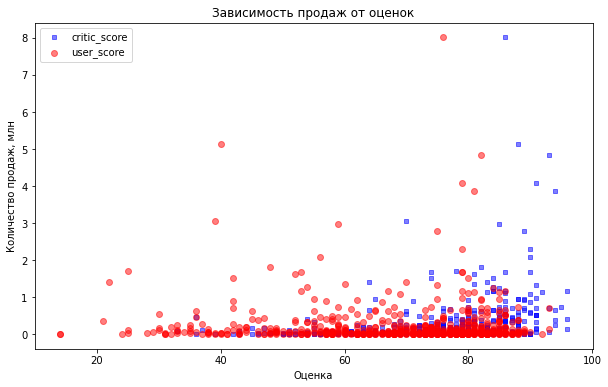

In [77]:
plt.figure(figsize=(10,6))

plt.scatter(PC['critic_score'], PC['total_sales'], alpha=0.5, s=10, c='b', marker="s", label='critic_score')
plt.scatter(PC['user_score_100'], PC['total_sales'], alpha=0.5, c='r', marker="o", label='user_score')

plt.title('Зависимость продаж от оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество продаж, млн')

plt.legend(loc='upper left')
plt.show()

In [78]:
corr_PC_critic = PC['critic_score'].corr(PC['total_sales'])
corr_PC_user = PC['user_score'].corr(PC['total_sales'])

print('Корреляция PC отзывы критиков к общим продажам:', f'{corr_PC_critic:.2f}')
print('Корреляция PC отзывы пользователей к общим продажам:', f'{corr_PC_user:.2f}')

Корреляция PC отзывы критиков к общим продажам: 0.29
Корреляция PC отзывы пользователей к общим продажам: -0.02


Тенденция осталась та же.

#####    Исследование игровых жанров
<a id="genre"></a>  

Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [79]:
# посмотрим на значения в жанрах
games_new['genre'].unique(), len(games_new['genre'].unique())

(array(['Sports', 'Racing', 'Platform', 'Misc', 'Action', 'Role-Playing',
        'Shooter', 'Fighting', 'Simulation', 'Adventure', 'Puzzle',
        'Strategy'], dtype=object),
 12)

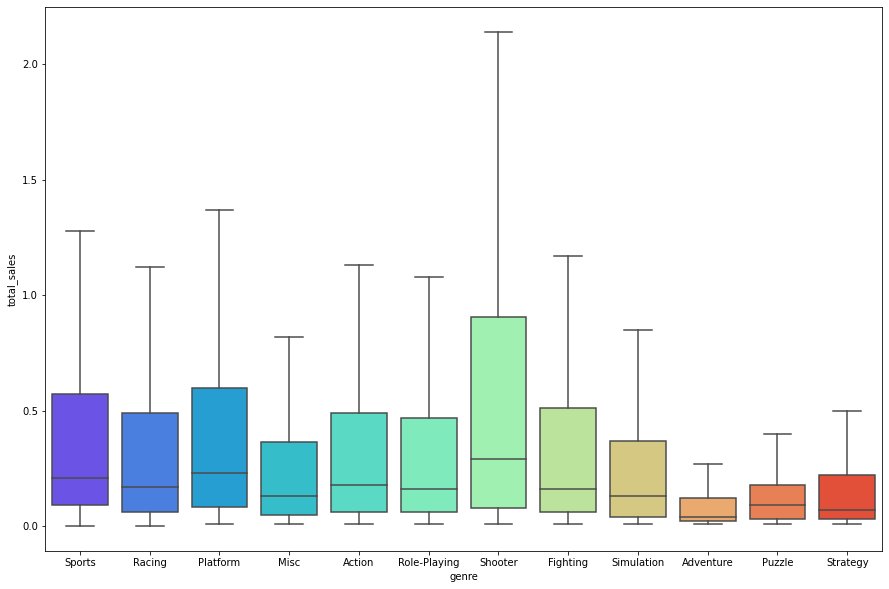

In [80]:
# график «ящик с усами» по жанрам и прибыли

fig, ax = plt.subplots()
sns.boxplot(x="genre", y="total_sales", data=games_new, palette='rainbow', showfliers=False)
fig.set_size_inches(15, 10)

Выделяются 'shooter'. Затем можно выделить 'sports', 'racing', 'platform' и 'fighting'. Судя по всему больше всего прибыли приносят жанры, в которых можно делать то, чего нельзя в жизни: убивать, драться и ставить себя в смертельноопасные ситуации. "Шутеры" скорее всего популярны, так как в них легко играть и не нужно изучать сложные правила, вести одну игру месяцами.

Меньше всего прибыли приносят приключенческие игры. На самом деле немного удивительно.. может, там мало экшена? И в них играют фанаты определенных фандомов?

### Портрет пользователя каждого региона
<a id="user"></a>

##### Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

##### Популярные платформы
<a id="topplatform"></a>

In [81]:
games_new.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,user_score_100
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,80.0
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,83.0
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,80.0
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80,85.0
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91,66.0


In [82]:
# cамые популярные платформы (топ-5) для NA, EU, JP

sales = ['na_sales', 'eu_sales', 'jp_sales']
platform_sales = games_new.groupby('platform').sum()[sales]
platform_sales

,na_sales,eu_sales,jp_sales
platform,,,
3DS,83.11,61.46,100.62
DS,325.06,143.30,141.49
PC,45.32,102.08,0.00
PS2,116.73,47.50,36.12
PS3,391.60,328.83,79.51
PS4,108.74,141.09,15.96
PSP,82.36,55.27,71.13
Wii,494.01,261.48,69.05
X360,591.47,269.30,12.04


In [83]:
# топ-5 для NA
top_plat_na = platform_sales[['na_sales']].sort_values(by='na_sales', ascending=False).head(5)
top_plat_na

,na_sales
platform,
X360,591.47
Wii,494.01
PS3,391.60
DS,325.06
PS2,116.73


In [84]:
# посчитаем доли продаж в процентах по региону 
100 * top_plat_na / games_new['na_sales'].sum()

,na_sales
platform,
X360,25.368429
Wii,21.188323
PS3,16.795910
DS,13.941978
PS2,5.006605


In [85]:
# топ-5 для EU
top_plat_eu = platform_sales[['eu_sales']].sort_values(by='eu_sales', ascending=False).head(5)
top_plat_eu

,eu_sales
platform,
PS3,328.83
X360,269.30
Wii,261.48
DS,143.30
PS4,141.09


In [86]:
100 * top_plat_eu / games_new['eu_sales'].sum()

,eu_sales
platform,
PS3,22.493331
X360,18.421233
Wii,17.886312
DS,9.802312
PS4,9.651139


In [87]:
# топ-5 для JP
top_plat_jp = platform_sales[['jp_sales']].sort_values(by='jp_sales', ascending=False).head(5)
top_plat_jp

,jp_sales
platform,
DS,141.49
3DS,100.62
PS3,79.51
PSP,71.13
Wii,69.05


In [88]:
100 * top_plat_jp / games_new['jp_sales'].sum()

,jp_sales
platform,
DS,26.885950
3DS,19.119827
PS3,15.108502
PSP,13.516133
Wii,13.120891


Топ-5 прибыльных платформ во всех регионах разные. В Северной Америке и Европе больше всего предпочитают X360, PS3 и Wii, в то время как в Японии на первым местах DS, 3DS и PS3. Похоже, в Японии по-прежнему популярны Nintendo, в то время, как в Северной Америке и Европе такие приставки популярны чуть меньше, тем не менее тоже входят в топ-5, скорее всего из-за ностальгического фактора.

Также, можно заметить, что около 80-90% рынка занимают топ-5 платформ. В Японии доли топ-5 платформ отличаются меньше, чем в других странах.

##### Популярные жанры
<a id="topgenre"></a>

In [89]:
# cамые популярные жанры (топ-5) для NA, EU, JP
sales = ['na_sales', 'eu_sales', 'jp_sales']

genre_sales = games_new.groupby('genre').sum()[sales]
genre_sales[['na_sales', 'eu_sales', 'jp_sales']]
genre_sales

,na_sales,eu_sales,jp_sales
genre,,,
Action,517.67,342.88,94.04
Adventure,59.61,36.88,27.16
Fighting,91.37,41.59,26.83
Misc,278.31,141.98,60.40
Platform,121.55,73.91,31.46
Puzzle,42.30,27.37,12.16
Racing,125.13,108.78,11.78
Role-Playing,196.26,108.53,160.88
Shooter,370.93,237.51,17.57


In [90]:
# топ-5 для NA
top_genre_na = genre_sales[['na_sales']].sort_values(by='na_sales', ascending=False).head(5)
top_genre_na

,na_sales
genre,
Action,517.67
Sports,392.41
Shooter,370.93
Misc,278.31
Role-Playing,196.26


In [91]:
# топ-5 для EU
top_genre_eu = genre_sales[['eu_sales']].sort_values(by='eu_sales', ascending=False).head(5)
top_genre_eu

,eu_sales
genre,
Action,342.88
Sports,248.76
Shooter,237.51
Misc,141.98
Racing,108.78


In [92]:
# топ-5 для JP
top_genre_jp = genre_sales[['jp_sales']].sort_values(by='jp_sales', ascending=False).head(5)
top_genre_jp

,jp_sales
genre,
Role-Playing,160.88
Action,94.04
Misc,60.40
Sports,47.56
Platform,31.46


Северная Америка и Европа разделяют свои вкусы и предпочитают action, sports, shooter, misc и racing. А Япония больше всего любит role-playing, но также популярны action, sports, misc. Очевидно, что игры с большим градусом адреналина и экшена популярны везде. Нужно отметить, что Япония славится своими ролевыми играми, и похоже, что японцы патриотично разделяют любовь к своему "национальному" игровому жанру. Возможно, на это влияет кульутра манги и аниме?

##### Влияние рейтинга ESRB
<a id="rating"></a>

In [93]:
# посмотрим на рейтинги
games_new['rating'].unique(), len(games_new['rating'].unique())

(array(['E', 'M', 'unknown', 'T', 'E10+', 'EC', 'RP'], dtype=object), 7)

In [94]:
# продажи по рейтингу для NA, EU, JP
sales = ['na_sales', 'eu_sales', 'jp_sales']

rating_sales = games_new.groupby('rating').sum()[sales]
rating_sales[['na_sales', 'eu_sales', 'jp_sales']]
rating_sales

,na_sales,eu_sales,jp_sales
rating,,,
E,785.74,452.73,114.66
E10+,309.58,171.48,33.58
EC,1.83,0.00,0.00
M,582.52,410.58,43.60
RP,0.00,0.03,0.00
T,423.79,235.17,82.54
unknown,228.06,191.91,251.88


In [95]:
# для NA
rating_na = rating_sales[['na_sales']].sort_values(by='na_sales', ascending=False)
rating_na

,na_sales
rating,
E,785.74
M,582.52
T,423.79
E10+,309.58
unknown,228.06
EC,1.83
RP,0.00


In [96]:
# для EU
rating_eu = rating_sales[['eu_sales']].sort_values(by='eu_sales', ascending=False)
rating_eu

,eu_sales
rating,
E,452.73
M,410.58
T,235.17
unknown,191.91
E10+,171.48
RP,0.03
EC,0.00


In [97]:
# для JP
rating_jp = rating_sales[['jp_sales']].sort_values(by='jp_sales', ascending=False)
rating_jp

,jp_sales
rating,
unknown,251.88
E,114.66
T,82.54
M,43.60
E10+,33.58
EC,0.00
RP,0.00


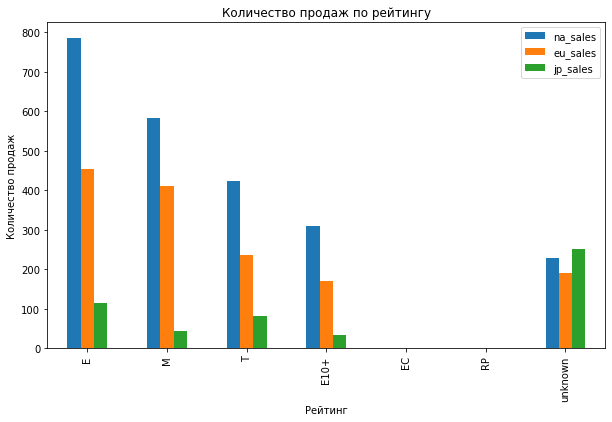

In [98]:
order = ['E', 'M', 'T', 'E10+', 'EC', 'RP', 'unknown']
ax = rating_sales[['na_sales', 'eu_sales', 'jp_sales']].reindex(order).plot.bar(figsize=(10,6))


ax.set_title('Количество продаж по рейтингу')
ax.set_xlabel('Рейтинг')
_ = ax.set_ylabel('Количество продаж')

Е (Everyone) - самый прибыльный рейтинг - тот, который покрывает наибольшее количество потенциальных пользователей. Вполне ожидаемо.

М (Mature), Т (Teen), E10+ (Everyone 10+) - тоже имеют понятно большие продажи - это, по-прежнему, основные группы игроков.

Интересно, что в Японии нет продаж для EC (Early Childhood), возможно, наш источник данных округлил данные только до сотых миллионов, и в нашей выборке нет данных по продажам данных игр в Японии. Также, в Японии игры для подростков продаются больше, чем с рейтингом М (Mature), возможно, что у взрослых японцев просто нет времени на игры, зная насколько они трудоголики.

Видим, что в Японии самую верхнюю позицию по продажам занимают игры без рейтинга. Также довольно высокие позиции игры без рейтинга занимают и в других регионах.

Причинами могут быть следующее: 
- Система ESRB имеет лейбл "Rating Pending" (RP),  т.е. "ждет оценки". Возможно, пропуски и есть игры, ждущие рейтинга. Правда надо учесть, что такой рейтинг используется только в демо-версиях до релиза. Возможно, часть продаж - платные демо-версии?
- Япония использует систему CERO для присвоение рейтинга играм, Северная Америка - ESRB, а Европа - PEGI. Возможно, из-за отсутствия одной системы оценок, такое большое количество игр имеет пропуски в нашей базе данных. Стоит проверить источник наших данных и разобраться, кто заполнял рейтинги, могли ли там как-то смешаться данные из разных источников.
- Самая популярная консоль в Японии - Nintendo Switch. Возможно, чуть ли не все игры на этой платформе подойдут для всех возрастных групп. Возможно такие игры не были помечены рейтингом, так как нет спорного контента, и в них могут играть все? И по сути, они имеют рейтинг E (Everyone).

### Проверка гипотез
<a id="hypothesis"></a>

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Задайте самостоятельно пороговое значение alpha.

Поясните:
- Как вы сформулировали нулевую и альтернативную гипотезы;
- Какой критерий применили для проверки гипотез и почему.

In [99]:
games_new.head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,user_score_100
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,80.0
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,83.0
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,80.0


In [100]:
# посмотрим названия платформ в нашем DataFrame
games_new['platform'].unique()

array(['Wii', 'DS', 'X360', 'PS3', 'PS4', '3DS', 'PC', 'XOne', 'PS2',
       'PSP'], dtype=object)

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC отличаются.


In [101]:
# проверка дисперсий выборок

XOne = games_new['platform'] == "XOne"
PC = games_new['platform'] == "PC"

var_Xone = np.var(XOne, ddof = 1)
var_PC = np.var(PC, ddof = 1)

var_Xone, var_PC

(0.024868004685956385, 0.07469941101080209)

In [102]:
# тест Левене

from scipy.stats import levene

stat, p = levene(XOne, PC)

print(stat, p)

302.5484465107944 2.97872608387701e-67


In [103]:
# тест Барлетта

from scipy.stats import bartlett

stat, p = bartlett(XOne, PC)
print(stat, p)

2790.5179564146283 0.0


In [104]:
# маски
XOne = games_new['platform'] == "XOne"
PC = games_new['platform'] == "PC"

alpha = .05

XOne = games_new['user_score'][XOne].dropna()
PC = games_new['user_score'][PC].dropna()

results = st.ttest_ind(XOne, PC)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.012225612285594961
Отвергаем нулевую гипотезу


In [105]:
# маски
XOne = games_new['platform'] == "XOne"
PC = games_new['platform'] == "PC"

alpha = .05

XOne = games_new['user_score'][XOne].dropna()
PC = games_new['user_score'][PC].dropna()

results = st.ttest_ind(XOne, PC, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 0.008603496501781193
Отвергаем нулевую гипотезу


Средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [106]:
games_new['genre'].unique()

array(['Sports', 'Racing', 'Platform', 'Misc', 'Action', 'Role-Playing',
       'Shooter', 'Fighting', 'Simulation', 'Adventure', 'Puzzle',
       'Strategy'], dtype=object)

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые.


Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.



In [107]:
# проверка дисперсий выборок

action = games_new['genre'] == "Action"
sports = games_new['genre'] == "Sports"

var_ation = np.var(action, ddof = 1)
var_sports = np.var(sports, ddof = 1)

var_ation, var_sports

(0.17308041649340525, 0.10930880222070616)

In [108]:
# тест Левене

from scipy.stats import levene

stat, p = levene(action, sports)

print(stat, p)

327.38501994155666 1.4139419838663877e-72


In [109]:
# тест Барлетта

from scipy.stats import bartlett

stat, p = bartlett(action, sports)
print(stat, p)

506.62154472946276 3.445676829479594e-112


In [110]:
# маски
action = games_new['genre'] == "Action"
sports = games_new['genre'] == "Sports"

alpha = .05

action = games_new['user_score'][action].dropna()
sports = games_new['user_score'][sports].dropna()

results = st.ttest_ind(action, sports)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 6.394764718916879e-11
Отвергаем нулевую гипотезу


In [111]:
# маски
action = games_new['genre'] == "Action"
sports = games_new['genre'] == "Sports"

alpha = .05

action = games_new['user_score'][action].dropna()
sports = games_new['user_score'][sports].dropna()

results = st.ttest_ind(action, sports, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 8.125697501458953e-10
Отвергаем нулевую гипотезу


Средние пользовательские рейтинги жанров Action и Sports различаются.

Для проверки гипотез использовали двусторонний тест, так как мы проверяем на различия двух независимых выборок. Уровень значимости выбрали как 0.05, так как это общепринятое значение в исследовательской среде.

### Общие выводы
<a id="conclusions"></a>

После проведения нашего исследовательского анализа мы можем предложить следующие критерии игр, которые с наибольшей уверенностью будут успешными и прибыльными: 

- Игры, которые имеют рейтинг E ("Для всех"), M ("Для взрослых") и T ("Для подростков")
- Жанры, которые беспроигрышно для всех категорий будут прибыльными - Action, Sports, Shooter
- Платформа PS4 будет только набирать обороты, в то время как популярные PS3 и X360 скорее всего полностью пропадут совсем скоро. А вот PC никуда не денется из-за своей доступности и распространенности.

На оценки критиков и пользователей можно не обращать пристольного внимания.

Так что рекламируем Fortnite, Wolfenstein II: The New Colossus и Prey :)